# CS145: Project 3 | Why is there a decline in Stackoverflow posts?


## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Rodrigo Ruz Cuen, SUNet ID: ruz*
* *Ryan Samedi, SUNet ID: rsamadi* 

Project Overview

Which elements contribute to the declining nunmber of Stackoverflow posts? In this project, we focused on several elements(including time, user longevity, programming language) that influence the decline in posts in the website.

## Project Overview

---

*The following notebook contains an exploratory analysis on the [StackOverflow public dataset](https://cloud.google.com/blog/topics/public-datasets/google-bigquery-public-datasets-now-include-stack-overflow-q-a) using BigQuery. Specifically, we make note of a clear decline in posts (questions & answers) on the site, starting from 2014. We discuss possible root causes for this phenomenon, whether StackOverflow should be worried, and possible solutions to expedite growth.*

*We explore four questions prompts: Q1: How has the number of posts in Stackoverflow changed over time?, Q2: Why has the number of posts in Stackoverflow declined?, Q3: Should Stackoverflow worry about this decline based on the number of users?, and Q4: What are some possible solutions to mitigate the decline in posts?*


---

## Analysis of Dataset

---

*Our exploration is performed on the [StackOverflow public dataset](https://cloud.google.com/blog/topics/public-datasets/google-bigquery-public-datasets-now-include-stack-overflow-q-a) using BigQuery. This dataset contains 16 tables (badges, comments, post_history, post_links, posts_answers, posts_moderator_nomination, posts_orphaned_tag_wiki,posts_privilege_wiki, posts_questions, posts_tag_wiki, posts_tag_wiki_excerpt, posts_wiki_placeholder, stackoverflow_posts, tags, users, and votes).*

*For Question prompt 1 and 2, we specifically focus on the posts_questions and the posts_answers tables, which are 37.17 GB and 28.62 GB in size, respectively. For question prompt 3, we specifically focus on the users table, which is 3.14 GB in size. These tables are also used to explore question prompt 4.*

---

# Import Dependencies

We begin by importing the necessary libraries

In [6]:
# Data storage
from google.cloud import bigquery

# Data analysis
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('darkgrid')

# Data Exploration

Explore the StackOverflow dataset from BigQuery's public data archives

In [7]:
# Initialize a client object to project ID
project_id = 'arctic-task-365900' # YOUR PROJECT ID HERE
client = bigquery.Client(project=project_id)
# Run this cell to authenticate yourself to BigQuery.
from google.colab import auth
auth.authenticate_user() 

# Construct a reference to the "stackoverflow" dataset
dataset_ref = client.dataset('stackoverflow', project='bigquery-public-data')

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

In [ ]:
# Print every table ID in the dataset
tables = list(client.list_tables(dataset))
for table in tables:  
    print(table.table_id)

badges
comments
post_history
post_links
posts_answers
posts_moderator_nomination
posts_orphaned_tag_wiki
posts_privilege_wiki
posts_questions
posts_tag_wiki
posts_tag_wiki_excerpt
posts_wiki_placeholder
stackoverflow_posts
tags
users
votes


# Question Prompt 1: How has the number of posts in Stackoverflow changed over time?
In this section we explore quantitatively, the decline in the number of posts (questions & answers) on StackOverflow since 2014.

In [8]:
# Query to select question & answer counts as a function of time
query = """
        WITH q AS (
            SELECT EXTRACT(YEAR FROM creation_date) AS year, COUNT(*) AS num_questions
            FROM `bigquery-public-data.stackoverflow.posts_questions`
            GROUP BY year
        ), 
        a AS (
            SELECT EXTRACT(YEAR FROM creation_date) AS year, COUNT(*) AS num_answers
            FROM `bigquery-public-data.stackoverflow.posts_answers`
            GROUP BY year
        ),
        cte AS (
            SELECT year, num_questions, num_answers,
            FROM q
            JOIN a
                USING(year)
        )
        SELECT 
            c1.year, 
            c1.num_questions,
            ROUND((c1.num_questions - c2.num_questions) / c1.num_questions * 100, 2) AS q_percent_diff,
            c1.num_answers, 
            ROUND((c1.num_answers - c2.num_answers) / c1.num_answers * 100, 2) AS a_percent_diff,
        FROM cte AS c1
        LEFT JOIN cte AS c2
            ON c1.year = c2.year + 1
        ORDER BY c1.year
        """

# Set up the query (cancel if greater than 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, then convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Print the resulting DataFrame
df

,year,num_questions,q_percent_diff,num_answers,a_percent_diff
0,2008,57569,NaN,209513,NaN
1,2009,341651,83.15,931215,77.50
2,2010,690840,50.55,1456666,36.07
3,2011,1189881,41.94,2264350,35.67
4,2012,1629386,26.97,2823422,19.80
5,2013,2033690,19.88,3314677,14.82
6,2014,2137435,4.85,3196317,-3.70
7,2015,2196676,2.70,3143467,-1.68
8,2016,2200802,0.19,3072291,-2.32
9,2017,2116212,-4.00,2903966,-5.80


In [9]:
# drop 2022 data since it's incomplete
df.drop(index=14, inplace=True)

<Figure size 432x288 with 0 Axes>

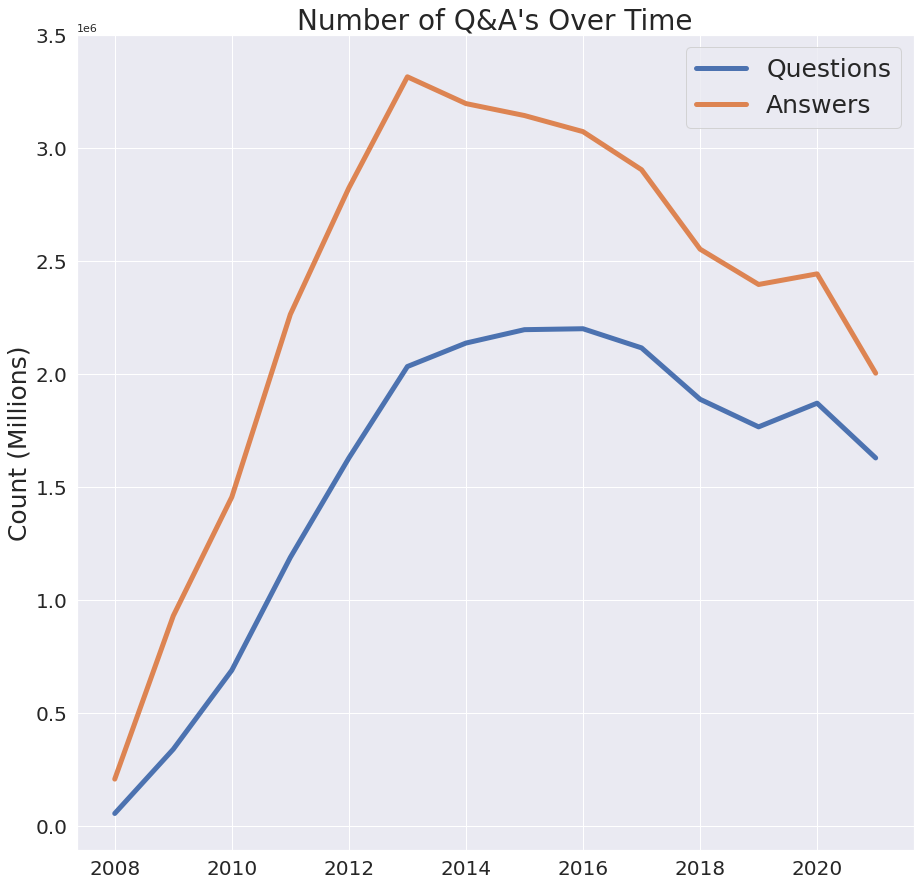

In [10]:
# Make line plot
fig = plt.figure()
ax = df.plot(x='year', y=['num_questions', 'num_answers'], kind='line', linewidth=5, figsize=(15, 15), fontsize=20)

# Customize plot
ax.set_title('Number of Q&A\'s Over Time', fontsize=28)
ax.set_xlabel('')
ax.set_ylabel('Count (Millions)', fontsize=25)
ax.set_yticks(ticks=[0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000])
ax.legend(['Questions', 'Answers'], fontsize=25)

# Save plot
plt.savefig('num_qna.png')

<Figure size 432x288 with 0 Axes>

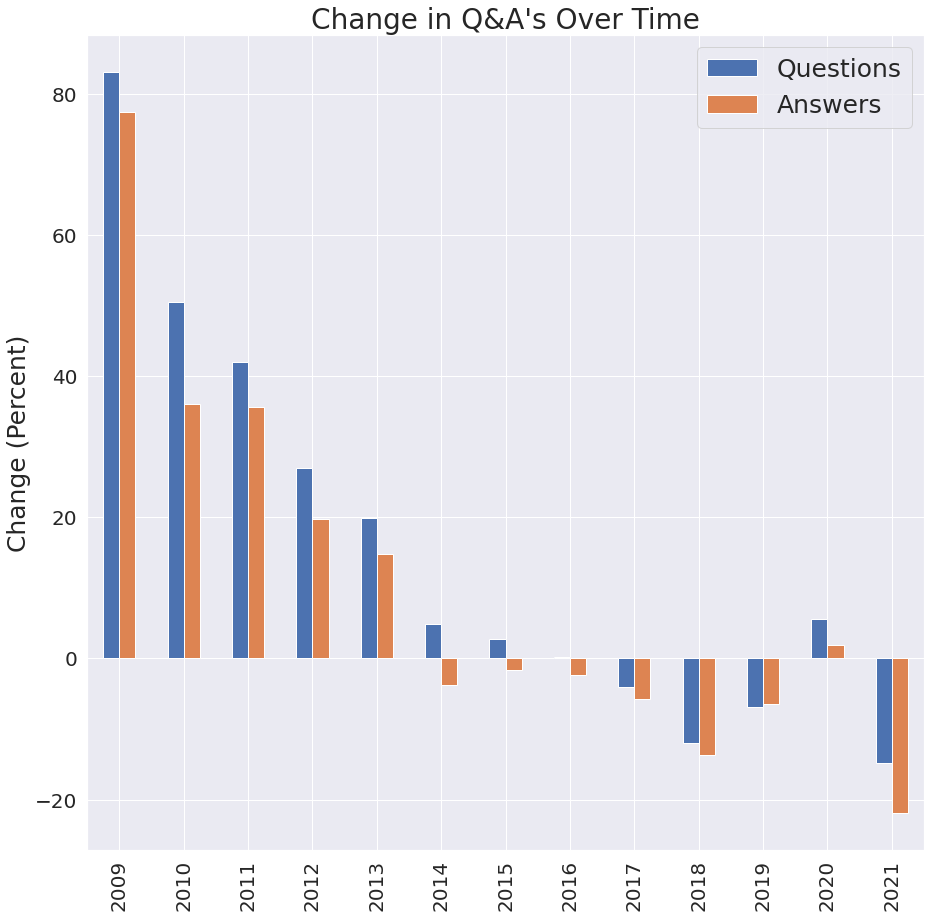

In [11]:
# Drop 2008 data since there's no change
df.drop(index=0, inplace=True)

# Make bar plot
fig = plt.figure()
ax = df.plot(x='year', y=['q_percent_diff', 'a_percent_diff'], kind='bar', figsize=(15, 15), fontsize=20)

# Customize plot
ax.set_title('Change in Q&A\'s Over Time', fontsize=28)
ax.set_xlabel('')
ax.set_ylabel('Change (Percent)', fontsize=25)
ax.set_yticks(ticks=[-20, 0, 20, 40, 60, 80])
ax.legend(['Questions', 'Answers'], fontsize=25)

# Question Prompt 2: Why has the number of posts in Stackoverflow declined?
In this section we use a root cause anslysis to explore the reason for the decline in the number of posts (questions & answers) on StackOverflow since 2014.

### Hypothesis 1: Easy questions have already been asked

One possible explanation is that the easier questions have already been asked, e.g. "how to make a plot in Python", "how to read a csv file in Pandas", "how to use SELECT statement in MySQL", etc.

In [ ]:
# Query to select most asked about technologies from 2008 to 2014
query = """
        WITH cte_1 AS (
            SELECT
                SPLIT(tags,'|') AS tech_name
            FROM `bigquery-public-data.stackoverflow.posts_questions`
            WHERE EXTRACT(YEAR FROM creation_date) >= 2008 AND EXTRACT(YEAR FROM creation_date) <= 2014
        ),
        cte_2 AS (
            SELECT
              tags,
              COUNT(*) AS num_questions
            FROM cte_1
            CROSS JOIN UNNEST(tech_name) AS tags
            GROUP BY tags
            ORDER BY num_questions DESC
            LIMIT 10
        )
        SELECT 
            tags,
            num_questions,
            ROUND(num_questions / SUM(num_questions) OVER() * 100, 2) AS percent_share
        FROM cte_2
        ORDER BY num_questions DESC
        """

# Set up the query (cancel if greater than 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, then convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Print the resulting DataFrame
df

,tags,num_questions,percent_share
0,java,732054,13.90
1,javascript,720791,13.69
2,c#,706528,13.41
3,php,643747,12.22
4,android,560816,10.65
5,jquery,535685,10.17
6,html,400611,7.61
7,python,360241,6.84
8,c++,325797,6.19
9,ios,280453,5.33


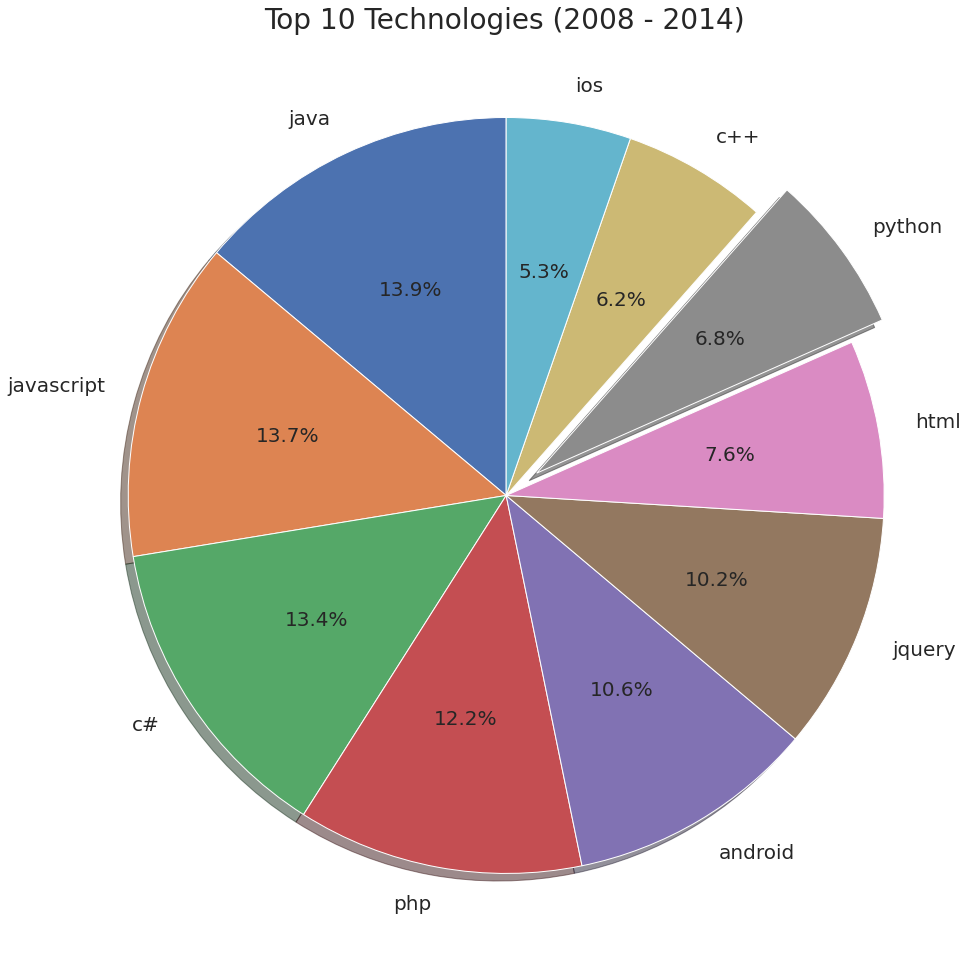

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df.tags
sizes = df.percent_share

# "Explode" the 2nd slice (i.e. 'Python')
explode = (0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0) 

# Make pie chart
fig1, ax = plt.subplots(figsize=(15, 17))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 20})

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Customize plot
ax.set_title('Top 10 Technologies (2008 - 2014)', fontsize=28)

# Save plot
plt.savefig('tech_distribution_2008.png')

In [ ]:
# Query to select most asked about technologies from 2015 to 2022
query = """
        WITH cte_1 AS (
            SELECT
                SPLIT(tags,'|') AS tech_name
            FROM `bigquery-public-data.stackoverflow.posts_questions`
            WHERE EXTRACT(YEAR FROM creation_date) >= 2015 AND EXTRACT(YEAR FROM creation_date) <= 2022
        ),
        cte_2 AS (
            SELECT
              tags,
              COUNT(*) AS num_questions
            FROM cte_1
            CROSS JOIN UNNEST(tech_name) AS tags
            GROUP BY tags
            ORDER BY num_questions DESC
            LIMIT 10
        )
        SELECT 
            tags,
            num_questions,
            ROUND(num_questions / SUM(num_questions) OVER() * 100, 2) AS percent_share
        FROM cte_2
        ORDER BY num_questions DESC
        """

# Set up the query (cancel if greater than 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, then convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Print the resulting DataFrame
df

,tags,num_questions,percent_share
0,javascript,1705779,18.59
1,python,1666360,18.16
2,java,1134001,12.36
3,c#,852853,9.30
4,android,825611,9.00
5,php,801980,8.74
6,html,745600,8.13
7,css,497716,5.42
8,jquery,493865,5.38
9,c++,451015,4.92


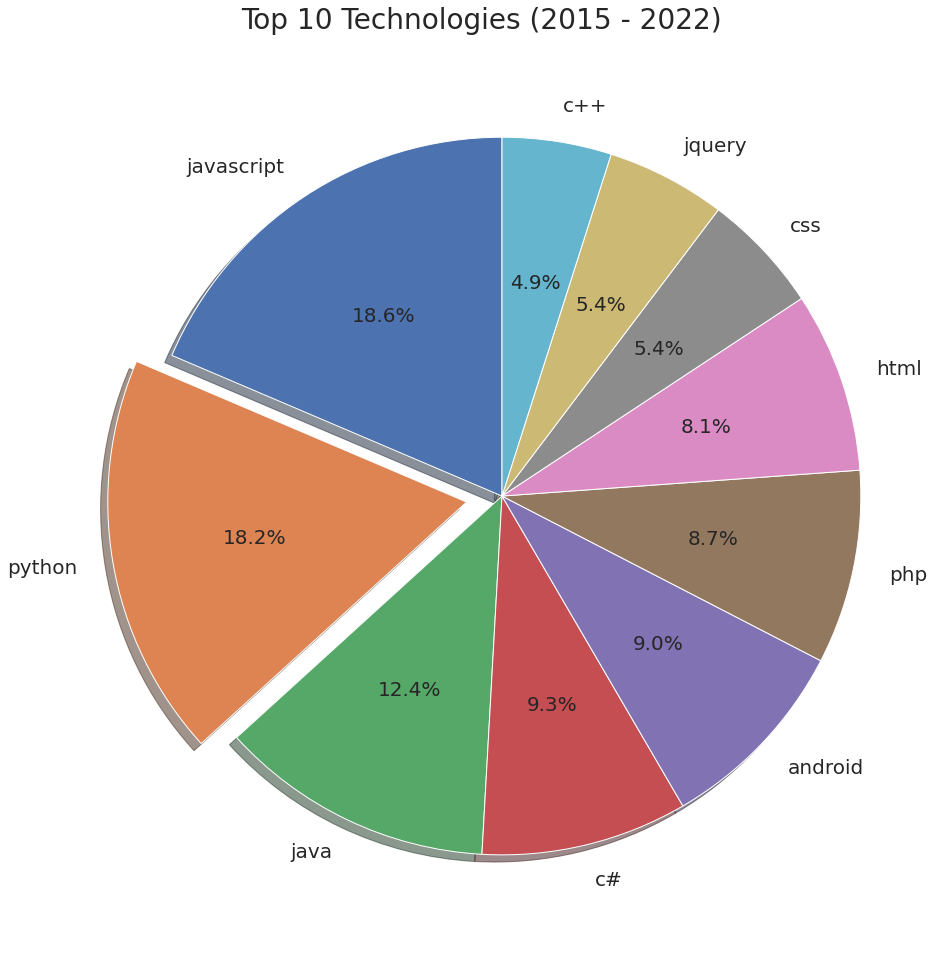

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df.tags
sizes = df.percent_share

# "Explode" the 2nd slice (i.e. 'Python')
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0) 

# Make pie chart
fig1, ax = plt.subplots(figsize=(15, 17))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 20})

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Customize plot
ax.set_title('Top 10 Technologies (2015 - 2022)', fontsize=28)

# Save plot
plt.savefig('tech_distribution_2015.png')

One possible explanation is that the easier questions (e.g. "how to make a plot in Python", "how to read a csv file in Pandas", "how to use SELECT statement in MySQL", etc.) have already been asked, leaving users with an increasingly small pool of more niche questions. This is evidenced by the observation that the top 10 most asked-about technologies on the site has remained largely unchanged pre-2014 vs post-2014. Notice from the pie charts above that while their distributions might vary, 90% of the top 10 languages are the same.

### Hypothesis 2: Toxicity

Another explanation may be that users (especially newer ones) feel increasingly intimidated to post questions, out of fear of being "downvoted" or criticized. 

In [ ]:
# Query to select number of positively scored questions over time
query = """
        SELECT
          EXTRACT(YEAR FROM creation_date) AS year,
          COUNT(*) AS num_questions,
          ROUND(SUM(IF(score > 0, 1, 0)) / COUNT(*) * 100, 2) AS percent_positive,
          ROUND(SUM(IF(score < 0, 1, 0)) / COUNT(*) * 100, 2) AS percent_negative
        FROM
          `bigquery-public-data.stackoverflow.posts_questions`
        GROUP BY year
        ORDER BY year
        """

# Set up the query (cancel if greater than 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, then convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Print the resulting DataFrame
df

,year,num_questions,percent_positive,percent_negative
0,2008,57569,89.35,0.62
1,2009,341651,73.71,1.17
2,2010,690840,70.85,1.32
3,2011,1189881,64.75,2.25
4,2012,1629386,60.10,3.83
5,2013,2033690,52.48,5.39
6,2014,2137435,45.85,7.03
7,2015,2196676,49.38,7.94
8,2016,2200802,47.79,8.18
9,2017,2116212,45.54,8.73


<Figure size 432x288 with 0 Axes>

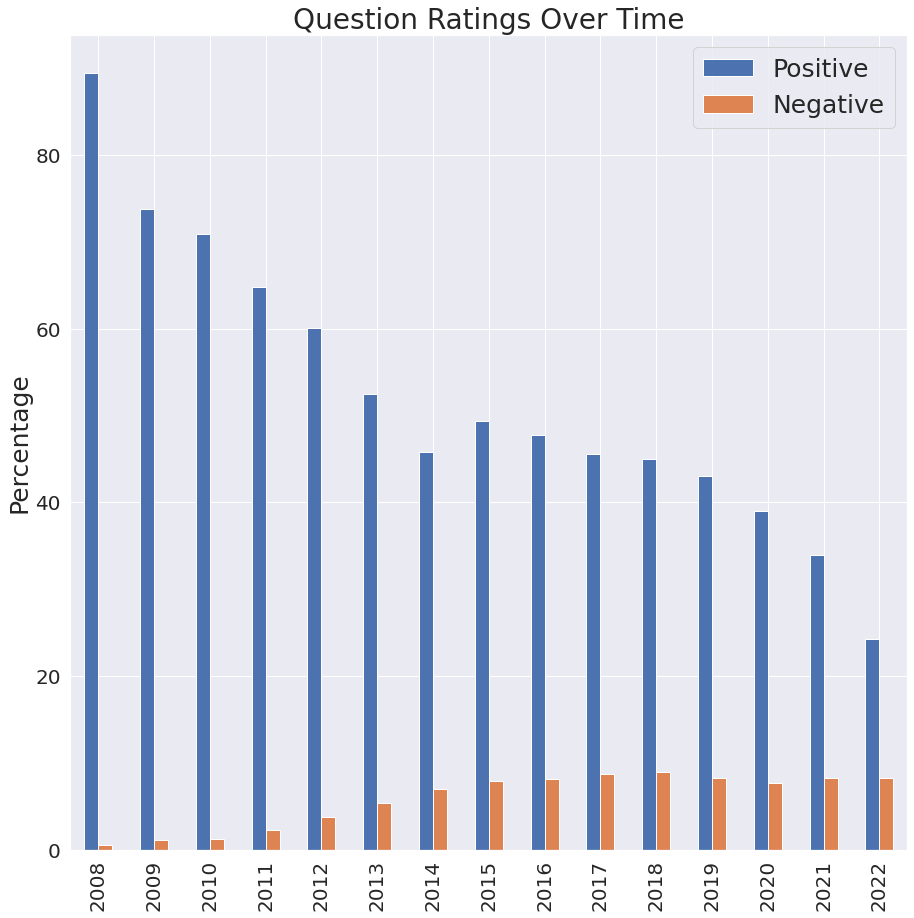

In [ ]:
# Make bar plot
fig = plt.figure()
ax = df.plot(x='year', y=['percent_positive', 'percent_negative'], kind='bar', figsize=(15, 15), fontsize=20)

# Customize plot
ax.set_title('Question Ratings Over Time', fontsize=28)
ax.set_xlabel('')
ax.set_ylabel('Percentage', fontsize=25)
ax.set_yticks(ticks=[0, 20, 40, 60, 80])
ax.legend(['Positive', 'Negative'], fontsize=25)

# Save plot
plt.savefig('q_ratings.png')

As evidenced by the declining positive ratings and increasing negative ratings towards questions posted to StackOverflow, it's not hard to imagine why new users may feel intimidated out of fear of asking "stupid questions".

# Question Prompt 3: Should Stackoverflow worry about this decline in posts?

Despite the clear downward trend in posts, is there any reason to worry from StackOverflow's perspective? Well, one useful metric to look at to answer this question is new user growth.

In [ ]:
# Query to select new_user and inactive_user counts as a function of time
query = """
        WITH cte_1 AS (
            SELECT EXTRACT(YEAR FROM creation_date) AS year, COUNT(*) AS num_new_users
            FROM `bigquery-public-data.stackoverflow.users`
            GROUP BY year
        ),
        cte_2 AS (
            SELECT 
                c1.year,
                c1.num_new_users,
                ROUND((c1.num_new_users - c2.num_new_users) / c1.num_new_users * 100, 2) AS u_percent_diff
            FROM cte_1 AS c1
            LEFT JOIN cte_1 AS c2
                ON c1.year = c2.year + 1
            ORDER BY c1.year
        ),
        cte_3 AS (
            SELECT 
                EXTRACT(YEAR FROM last_access_date) AS last_accessed_year,
                2022 - EXTRACT(YEAR FROM last_access_date) AS years_inactive,
                COUNT(*) AS num_inactive_users
            FROM `bigquery-public-data.stackoverflow.users`
            GROUP BY last_accessed_year, years_inactive
            ORDER BY last_accessed_year
        )
        SELECT c_2.year, c_2.num_new_users, c_3.num_inactive_users
        FROM cte_2 AS c_2
        JOIN cte_3 AS c_3
            ON c_2.year = c_3.last_accessed_year
        ORDER BY c_2.year
        """

# Set up the query (cancel if greater than 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, then convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Print the resulting DataFrame
df

,year,num_new_users,num_inactive_users
0,2008,21638,1629
1,2009,77968,14803
2,2010,199127,88036
3,2011,358579,157425
4,2012,678472,246413
5,2013,1121735,531889
6,2014,1173861,693588
7,2015,1251327,899913
8,2016,1514107,957667
9,2017,1724826,1283007


In [ ]:
# Drop 2022 data since it's incomplete
df.drop(index=14, inplace=True)

<Figure size 432x288 with 0 Axes>

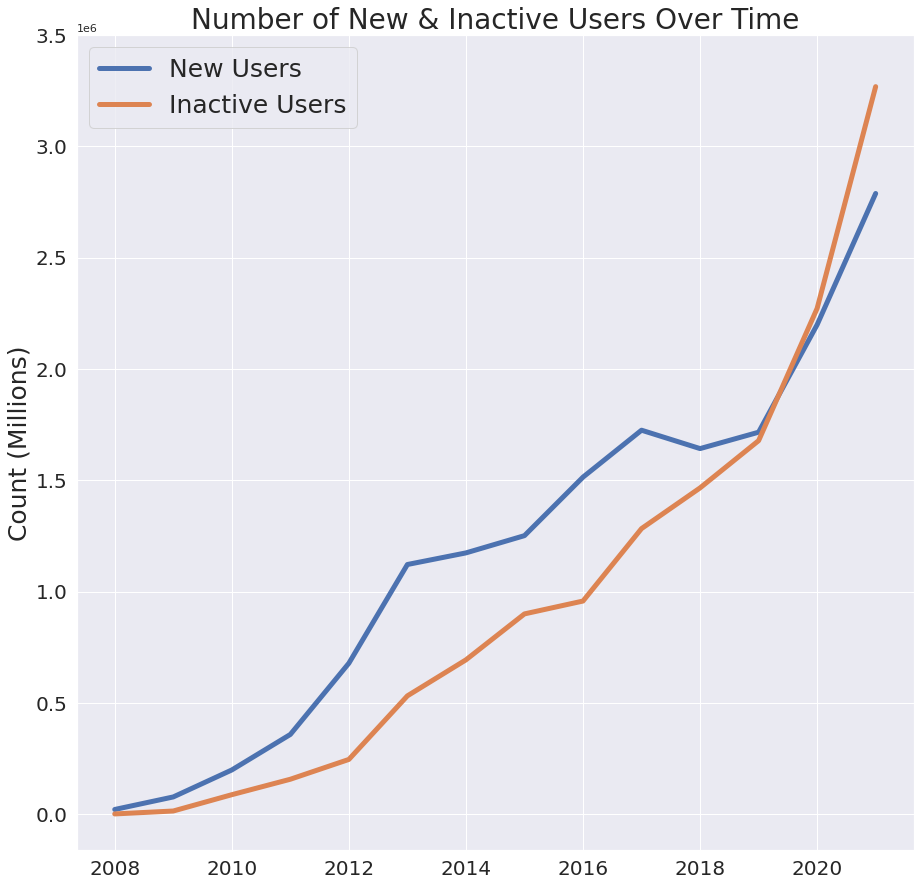

In [ ]:
# Make line plot
fig = plt.figure()
ax = df.plot(x='year', y=['num_new_users', 'num_inactive_users'], kind='line', linewidth = 5, figsize=(15, 15), fontsize=20)

# Customize plot
ax.set_title('Number of New & Inactive Users Over Time', fontsize=28)
ax.set_xlabel('')
ax.set_ylabel('Count (Millions)', fontsize=25)
ax.set_yticks(ticks=[0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000])
ax.legend(['New Users', 'Inactive Users'], fontsize=25)

# Save plot
plt.savefig('user_activity.png')

Notice, the number of new users per year has been steadily climbing, which may provide StackOverflow a sigh of relief. However, somewhat worryingly, the number of inactive users per year has also been increasing, and in 2019, this user-base surpased the aforementioned new-user growth. While this is to be expected, since more users would naturally lead to more inactive users, the relative gap between the two trends should still be addressed.

# Question prompt 4: What are some possible solutions to mitigate the decline in posts?

In this section we seek to explore if there are possible steps StackOverflow can take to accelerate user growth while maintaining user retention

In [ ]:
# Query to select avg_questions_per_year as a function of account creation time
query = """
        WITH cte_1 AS (
            SELECT
                u.id,
                EXTRACT(YEAR FROM u.creation_date) AS year,
                COUNT(*) AS num_questions
            FROM `bigquery-public-data.stackoverflow.users` AS u
            LEFT JOIN `bigquery-public-data.stackoverflow.posts_questions` AS q
                ON u.id = q.owner_user_id
            GROUP BY year, u.id
        ),
        cte_2 AS (
            SELECT
                id,
                year,
                num_questions / (2022 - year + 1) AS num_questions_per_year
            FROM cte_1
        )
        SELECT
            year,
            AVG(num_questions_per_year) AS avg_num_questions_per_year
        FROM cte_2
        GROUP BY year
        ORDER BY year
        """

# Set up the query (cancel if greater than 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, then convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Print the resulting DataFrame
df

,year,avg_num_questions_per_year
0,2008,1.219728
1,2009,1.042269
2,2010,0.654797
3,2011,0.588904
4,2012,0.411619
5,2013,0.299152
6,2014,0.277036
7,2015,0.277755
8,2016,0.261079
9,2017,0.265929


<Figure size 432x288 with 0 Axes>

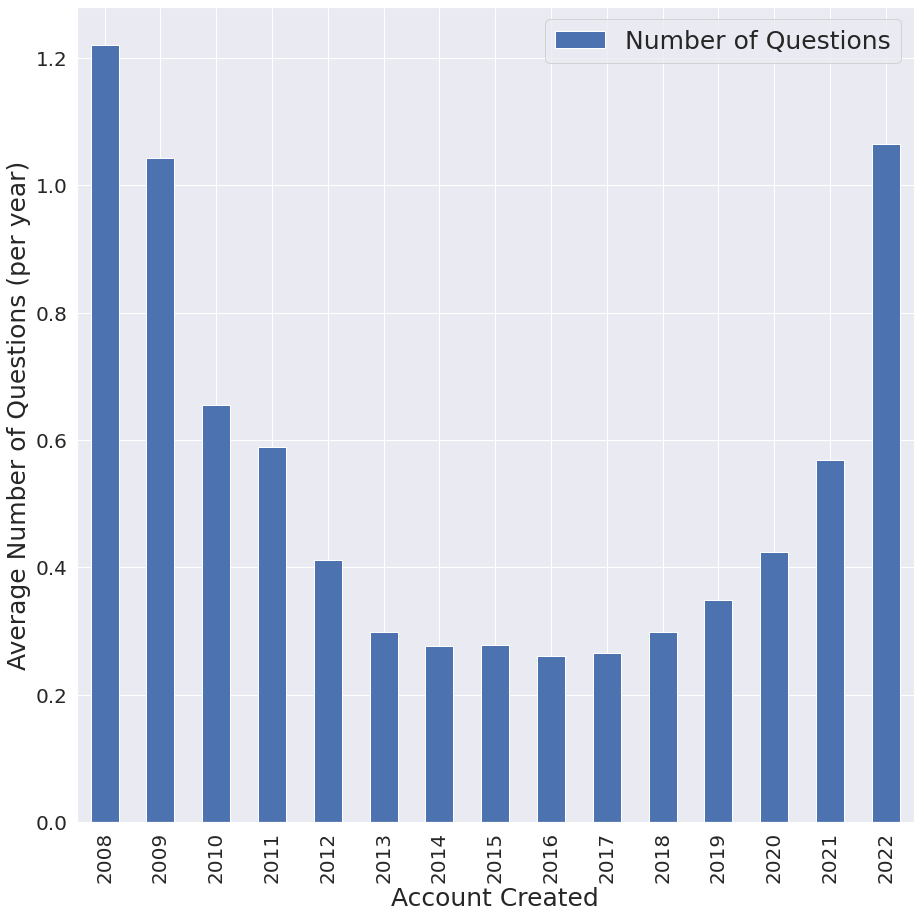

In [ ]:
# Make bar plot
fig = plt.figure()
ax = df.plot(x='year', y='avg_num_questions_per_year', kind='bar', figsize=(15, 15), fontsize=20)

# Customize plot
ax.set_xlabel('Account Created', fontsize=25)
ax.set_ylabel('Average Number of Questions (per year)', fontsize=25)
ax.legend(['Number of Questions'], fontsize=25)

# Save plot
plt.savefig('avg_questions_vs_age.png')

Interestingly, when looking at the average number of questions per year, with respect to account creation year, we find that users who joined early on during the site's launch in 2008, and users who joined very recently, are the ones posting the most questions! Conversely, users who've been on the site for a few years but are not part of the most recent users or the original ones, are the users asking the least questions. 

This implies that the most recent users may be acting as gatekeepers, with new users initially eager to ask questions, but as time goes on, they become increasingly tired, and thus less likely to make new posts (some, even abandoning the site altogether). 

Hence, we suggest that StackOverflow police toxicity by introducing an automated filter for clear and obvious non-answers (e.g. "why would you even ask that", "this question has already been asked stupid", etc.). Additionally, StackOverflow could provide users with more incentives for asking and answering questions, such as virtual currency that could be exchanged for merchandise. 

# Data Prediction

---
Our main objective for this aspect of the data prediction was predicting the future popularity of a given stackoverflow post. We will accomplish this using multiple iterations of a linear regression with different features at each point which more accurately represent the dataset.

The driving force behind using this as our predictive metric is that in determining the long term integrity of stackoverflow as a platform, what is wholly crucial to the integrity of the actual users is the ability to create a post with increased user retention. Thus, by using different aspects of the post from the BigQuery dataset, we see that we can more accurately predict the resultant score of a given post, or the performance of that post on the platform. 

Following the initial linear regression, I found that there were better metrics within the dataset that would allow us to reduce our resultant errors in the dataset as a whole.

---

# Linear Regression

---

We will use a combination of several factors to make predictions. We will attempt to make predictions for the long term score of a post, since that is a core metric that we seek to track. 

We divide the dataset in the following manner: 
- Train: 2013-2014 Stackoverflow Data
- Validation: 2014-2015 Stackoverflow Data
-Last 2015-2016 Stackoverflow Data (Test)

We will test a few features that appeared to have at least some level of correlation in our analysis: the number of comments on that post, the last activity date, and the last edit date as our original metrics.
---

In [17]:
# Run this cell to create a dataset to store your model, or create in the UI

model_dataset_name = 'stackoverflowdataset'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('arctic-task-365900', 'stackoverflowdataset'))

In [49]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `stackoverflowdataset.lrmodel`
OPTIONS(model_type = 'linear_reg', input_label_cols=['label']) 
AS
Select score as label, comment_count as feature_3, last_activity_date as feature_4, last_edit_date as feature_5, view_count as feature_6
from `bigquery-public-data.stackoverflow.stackoverflow_posts`
where creation_date between '2013-01-01' AND '2014-01-01'

Query is running:   0%|          |

""


Our rationale for picking these values initially was the notion of there being relevance in the quantity of engagement with a given post (i.e the number of comments) as a good engagement metric. We believed that comments in this case would be a more important metric in terms of measuring the engagement of users from an actual activity standpoint, while the number of views that a post were to actually garner is a more important metric in terms of actual activity and virality of a post. This was actually a notable question in our discussion and methodology, because of the fact that the presence of a higher view count for a post, but dwindling comment count could have been a potential explanation of why the dynamic of the platform was changing. More specifically, it was crucial to explore the nuanced differences between both of these aspects while also paying attention to the inception of the post and its most recent activity.

In [50]:
%%bigquery --project $project_id
Select count(*)
from `bigquery-public-data.stackoverflow.stackoverflow_posts`
where creation_date between '2014-01-01' AND '2015-01-01'

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,5431540


This was meant to validate the size in rows of our training dataset for every iteration (train, test, validation).

In [38]:
%%bigquery --project $project_id
# Run cell to view training stats

SELECT
*
FROM
 ML.TRAINING_INFO(MODEL `stackoverflowdataset.lrmodel`)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,99.187273,312.714502,NaN,24780


In [51]:
%%bigquery --project $project_id
SELECT
  *
FROM
  ML.EVALUATE(MODEL `stackoverflowdataset.lrmodel`, (
Select score as label, comment_count as feature_3, last_activity_date as feature_4, last_edit_date as feature_5, view_count as feature_6
from `bigquery-public-data.stackoverflow.stackoverflow_posts`
where creation_date between '2013-01-01' AND '2014-01-01')) 

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.102769,93.428939,0.605736,1.060019,0.095081,0.095081


These initial results allow us to begin to evaluate the validity of our results with respect to our given objective. Our mean_squared_error values were particularly high, so an objective in a following iteration could be to minimize that value. Additionally, a mean_absolute_error of 2.102 indicates room for growth on our features in terms of both their accuracy and relevance to the overall score. We were able to iterate on this practice by engineering our own features while also staying true to other metrics already present within the dataset.

In [44]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `stackoverflowdataset.lrmodel_v2`
OPTIONS(model_type = 'linear_reg', input_label_cols=['label']) 
AS
Select score as label, comment_count as feature_3, date_diff(last_activity_date, creation_date, DAY) as feature_4
from `bigquery-public-data.stackoverflow.stackoverflow_posts`
where creation_date between '2013-01-01' AND '2014-01-01'

Query is running:   0%|          |

""


In [45]:
%%bigquery --project $project_id
SELECT
  *
FROM
  ML.EVALUATE(MODEL `stackoverflowdataset.lrmodel_v2`, (
Select score as label, comment_count as feature_3, date_diff(last_activity_date, creation_date, DAY) as feature_4
from `bigquery-public-data.stackoverflow.stackoverflow_posts`
where creation_date between '2015-01-01' AND '2016-01-01'
  )) 

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1.550711,151.948075,0.541355,0.853816,-0.000092,0.002009


Further analysis:

Our main distinction across either of the two runnings was the notion that we payed attention to the difference between the creation_date and the last activity date. We found this to be a fairly apt metric as far as determining the utility of a given post, and we believe that the improvement in both the mean_absolute_error and the mean_squared_log_error tends to reflect this fact. Additionally, one of our objectives in reducing the mean_squared_error across the two iterations was not met, but we believe that our choices for the data in the second iteration, while similar, were much more relevant. The increase in mean_squared_error tends to do with the inherent variance of the data itself, which intuitively can be because posts can become cyclically relevant as different aspects of the technology can go in and out of favor.

In [48]:
%%bigquery --project $project_id

# YOUR QUERY HERE
SELECT *
FROM
  ML.PREDICT(MODEL `stackoverflowdataset.lrmodel_v2`, (Select score as label, comment_count as feature_3, date_diff(last_activity_date, creation_date, DAY) as feature_4
from `bigquery-public-data.stackoverflow.stackoverflow_posts`
where creation_date between '2010-01-01' AND '2011-01-01'))
LIMIT 10


Query is running:   0%|          |

Downloading:   0%|          |

,predicted_label,label,feature_3,feature_4
0,0.763389,1,0,0
1,0.763389,0,0,0
2,0.763389,0,0,0
3,0.763389,0,0,0
4,0.763389,0,0,0
5,0.763389,1,0,0
6,0.763389,1,0,0
7,0.763389,0,0,0
8,0.763389,5,0,0
9,0.763389,1,0,0


Points of further exploration:

While our core error statistics may have improved, there are a variety of aspects that we can tweak in order to make our insights more accurate, be it by adding more features or solving our issue with the learning rate. Ultimately this dataset was very accessible in terms of its interchangability and abundance of data, which led to some interesting insights for us to leverage and ultimately assist in the future of the platform.

# Conclusions

---

*In this project we sought to explore the trend in posts in the Stackoverflow platform. We explored four questions prompts: Q1: How has the number of posts in Stackoverflow changed over time?, Q2: Why has the number of posts in Stackoverflow declined?, Q3: Should Stackoverflow worry about this decline based on the number of users?, and Q4: What are some possible solutions to mitigate the decline in posts? For Q1 specifically, we notice a clear decline in posts starting in the year 2014.*

*One possible explanation for Q2 is that the easier questions (e.g. "how to make a plot in Python", "how to read a csv file in Pandas", "how to use SELECT statement in MySQL", etc.) have already been asked, leaving users with an increasingly small pool of more niche questions. This is evidenced by the observation that the top 10 most asked-about technologies on the site has remained largely unchanged pre-2014 vs post-2014. Notice from the pie charts below, while their distributions might vary, 90% of the top 10 are the same. Additionally, we also explored platform tocixity and noticed that users (especially newer ones) may feel increasingly intimidated to post questions, out of fear of being downvoted or criticized by the community. In fact, we see a clear downward trend in posts that receive positive ratings, and a corresponding upward trend in posts that receive negative ratings.*


*In order to explore if the decline in number of posts should be a reason for the Stackoverflow administrators we looked at the current user base. Specifically, we noticed from the data that new user growth has been on the rise since 2008. However, the number of inactive users has also been increasing over the same time interval. Most worryingly, in 2019, this user base exceeded the number of new users the site was bringing in, and has only gotten worse with time. While it's natural to expect a growing number of new users to lead to more inactive users, the worsening relative gap between the two trends should still be addressed.*

*In order to explore Q4 and some possible solutions based on the data, when looking at the average number of questions per year with respect to account creation year, we find that users who joined early on during the site's launch in 2008, and users who joined very recently, are the ones posting the most questions! Conversely, users who've been on the site for a few years but are somewhat removed from the early birds are the ones asking the least questions. This implies that the early birds may be acting as gatekeepers, with new users initially eager to ask questions, but as time goes on, they become increasingly jaded, and thus less likely to make new posts (some, even abandoning the site altogether). Hence, we suggest that StackOverflow police toxicity by introducing an automated filter for clear and obvious non-answers (e.g. "why would you even ask that", "this question has already been asked stupid", etc.). Additionally, StackOverflow could provide users with more incentives for asking and answering questions, such as virtual currency that could be exchanged for merch.

As far as our final prediction, we found a great deal of utility in tracking our predicted metric with our updated features, and found that the problem we intended to solve was quite reasonable given the constraints of the dataset itself and our independent considerations of it. Moreover, the utility of these insights are quite vast in terms of our ability to help in the user retention of the platform moving forward. Which we, as CS majors, are vehemently in favor of doing!
*

---